# Compare RAGIS ice-sheet wide timeseries to IMBIE

In [ ]:
from datetime import datetime
import numpy as np
import pylab as plt
import xarray as xr
from glob import glob
import pandas as pd
import os

import seaborn as sns

from pismragis.observations import load_imbie, load_imbie_csv
from pismragis.analysis import resample_ensemble_by_data
from pismragis.processing import convert_netcdf_to_dataframe, check_file, copy_file
from pismragis.sensitivity import sensitivity_analysis
from pismragis.stats import run_stats

In [7]:
n_jobs = 8
norm_year = 1992.0

plt.rc('font', size=6)
plt.style.use("tableau-colorblind10")

mass_varname = f"Contribution to sea-level since {int(norm_year)} (cm SLE)"
discharge_varname = "D (Gt/yr)"
discharge_uncertainty_varname = "D uncertainty (Gt/yr)"
smb_varname = "SMB (Gt/yr)"
smb_uncertaintyvarname = "SMB uncertainty (Gt/yr)"


bg_color = "#216779"
bg_color = "w"
sim_colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][1::]
imbie_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
    
kg2cmsle = 1 / 1e12 * 1.0 / 362.5 / 10.0
gt2cmsle = 1 / 362.5 / 10.0
sigma = 2

## Load IMBIE

In [8]:
imbie = load_imbie(url="../imbie_dataset_greenland_dynamics-2020_02_28.xlsx")
# imbie = load_imbie_csv(url="../data/imbie_greenland_2021_Gt.csv")

glob PISM scalar time series files

In [4]:
data_dir = "../hindcasts"

experiments = []

exp = {
    "Experiment": "salinity",
    "proj_dir": "2023_04_ocean_calving_50",
    "scalar_dir": "scalar",
    "processed_dir": "processed",
    "lhs": "gris_ragis_ocean_calving_lhs_50_w_posterior",
}

ens_file = os.path.join(data_dir, exp["proj_dir"], "uq", f"""{exp["lhs"]}.csv""")
s_dir = os.path.join(data_dir, exp["proj_dir"], exp["scalar_dir"])
scalar_files = sorted(glob(os.path.join(s_dir, "ts_gris_g*00m_v20*RAGIS_id_*_1980-1-1_2020-1-1.nc")))
processed_path = os.path.join(data_dir, exp["proj_dir"], exp["processed_dir"])


for scalar_file in scalar_files:
    if check_file(scalar_file):
        copy_file(scalar_file, processed_path)
        
processed_files = sorted(glob(os.path.join(processed_path, "ts_gris_g*00m_v20*RAGIS_id_*_1980-1-1_2020-1-1.nc")))

exp_df = convert_netcdf_to_dataframe(processed_files, resample="yearly", verbose=False, n_jobs=n_jobs)
exp_df["Experiment"] = exp["Experiment"]
exp["data_df"] = exp_df
exp["run_stats"] = run_stats(processed_files, experiment=exp["Experiment"])
sa_df = sensitivity_analysis(exp_df.dropna(), ensemble_file=ens_file, n_jobs=n_jobs)
exp["sensitivity_df"] = sa_df
experiments.append(exp)

exp = {
    "Experiment": "tct",
    "proj_dir": "2023_04_thickness_calving_50",
    "scalar_dir": "scalar",
    "processed_dir": "processed",
    "lhs": "gris_ragis_thickness_calving_lhs_50_w_posterior",
}

ens_file = os.path.join(data_dir, exp["proj_dir"], "uq", f"""{exp["lhs"]}.csv""")
s_dir = os.path.join(data_dir, exp["proj_dir"], exp["scalar_dir"])
scalar_files = sorted(glob(os.path.join(s_dir, "ts_gris_g*00m_v20*RAGIS_id_*_1980-1-1_2020-1-1.nc")))
processed_path = os.path.join(data_dir, exp["proj_dir"], exp["processed_dir"])


for scalar_file in scalar_files:
    if check_file(scalar_file):
        copy_file(scalar_file, processed_path)
        
processed_files = sorted(glob(os.path.join(processed_path, "ts_gris_g*00m_v20*RAGIS_id_*_1980-1-1_2020-1-1.nc")))

exp_df = convert_netcdf_to_dataframe(processed_files, resample="yearly", verbose=False, n_jobs=n_jobs)
exp_df["Experiment"] = exp["Experiment"]
exp["data_df"] = exp_df
exp["run_stats"] = run_stats(processed_files, experiment=exp["Experiment"])
sa_df = sensitivity_analysis(exp_df.dropna(), ensemble_file=ens_file, n_jobs=n_jobs)
exp["sensitivity_df"] = sa_df
experiments.append(exp)

# exp = {
#     "Experiment": "frontal melt",
#     "proj_dir": "2023_04_ocean_50",
#     "scalar_dir": "scalar",
#     "processed_dir": "processed",
#     "lhs": "gris_ragis_ocean_lhs_50_w_posterior",
# }

# ens_file = os.path.join(data_dir, exp["proj_dir"], "uq", f"""{exp["lhs"]}.csv""")
# s_dir = os.path.join(data_dir, exp["proj_dir"], exp["scalar_dir"])
# scalar_files = sorted(glob(os.path.join(s_dir, "ts_gris_g*00m_v20*RAGIS_id_*_1980-1-1_2020-1-1.nc")))
# processed_path = os.path.join(data_dir, exp["proj_dir"], exp["processed_dir"])


# for scalar_file in scalar_files:
#     if check_file(scalar_file):
#         copy_file(scalar_file, processed_path)
        
# processed_files = sorted(glob(os.path.join(processed_path, "ts_gris_g*00m_v20*RAGIS_id_*_1980-1-1_2020-1-1.nc")))

# exp_df = convert_netcdf_to_dataframe(processed_files, resample="yearly", verbose=False, n_jobs=n_jobs)
# exp_df["Experiment"] = exp["Experiment"]
# exp["data_df"] = exp_df
# exp["run_stats"] = run_stats(processed_files, experiment=exp["Experiment"])
# sa_df = sensitivity_analysis(exp_df.dropna(), ensemble_file=ens_file, n_jobs=n_jobs)
# exp["sensitivity_df"] = sa_df
# experiments.append(exp)

# exp = {
#     "Experiment": "ctrl",
#     "proj_dir": "2023_04_ocean_simple_50",
#     "scalar_dir": "scalar",
#     "processed_dir": "processed",
#     "lhs": "gris_ragis_ocean_simple_lhs_50_w_posterior",
# }

# ens_file = os.path.join(data_dir, exp["proj_dir"], "uq", f"""{exp["lhs"]}.csv""")
# s_dir = os.path.join(data_dir, exp["proj_dir"], exp["scalar_dir"])
# scalar_files = sorted(glob(os.path.join(s_dir, "ts_gris_g*00m_v20*RAGIS_id_*_1980-1-1_2020-1-1.nc")))
# processed_path = os.path.join(data_dir, exp["proj_dir"], exp["processed_dir"])


# for scalar_file in scalar_files:
#     if check_file(scalar_file):
#         copy_file(scalar_file, processed_path)
        
# processed_files = sorted(glob(os.path.join(processed_path, "ts_gris_g*00m_v20*RAGIS_id_*_1980-1-1_2020-1-1.nc")))

# exp_df = convert_netcdf_to_dataframe(processed_files, resample="yearly", verbose=False, n_jobs=n_jobs)
# exp_df["Experiment"] = exp["Experiment"]
# exp["data_df"] = exp_df
# exp["run_stats"] = run_stats(processed_files)
# sa_df = sensitivity_analysis(exp_df.dropna(), ensemble_file=ens_file, n_jobs=n_jobs)
# exp["sensitivity_df"] = sa_df
# experiments.append(exp)



Converting netcdf files to pandas.DataFrame
-------------------------------------------


Processing files: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:04<00:00, 10.53it/s]


Conversion finished in 4 seconds
-------------------------------------------


Processing file: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:08<00:00,  4.86it/s]


Converting netcdf files to pandas.DataFrame
-------------------------------------------


Processing files: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:02<00:00, 16.08it/s]


Conversion finished in 3 seconds
-------------------------------------------


Processing file: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:09<00:00,  4.53it/s]


Peformace Summary for Experiment salinity (45 members)
---------------------------------------------------

processor_hours                   50503.283537
wall_clock_hours                    631.291044
model_years_per_processor_hour        0.038783
dtype: float64
---------------------------------------------------

Peformace Summary for Experiment tct (45 members)
---------------------------------------------------

processor_hours                   49289.110908
wall_clock_hours                    616.113886
model_years_per_processor_hour        0.038549
dtype: float64
---------------------------------------------------



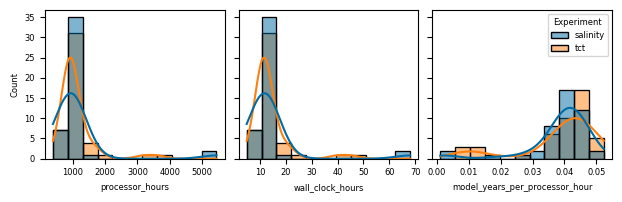

In [5]:
plt.rc('font', size=6)
plt.style.use("tableau-colorblind10")

e = experiments[0]["run_stats"]
m_vars = ["processor_hours", "wall_clock_hours", "model_years_per_processor_hour"]
for m in range(len(experiments)):
    e_df = experiments[m]["run_stats"]
    print(f"""Peformace Summary for Experiment {experiments[m]["Experiment"]} ({len(e_df)} members)""")
    print("---------------------------------------------------\n")
    print(e_df.agg({'processor_hours': 'sum', 'wall_clock_hours': "sum", "model_years_per_processor_hour": "mean"}))
    print("---------------------------------------------------\n")

fig, axs = plt.subplots(nrows=1, ncols=len(m_vars), sharey="row", figsize=[6.2, 2.0])
fig.subplots_adjust(wspace=0)


all_run_stats = pd.concat([experiments[k]["run_stats"] for k in range(len(experiments))]).reset_index(drop=True)
[sns.histplot(data=all_run_stats, x=m_var, bins=11, kde=True, hue="Experiment", ax=axs[k]) for k, m_var in enumerate(m_vars)]
axs[0].legend([], [], frameon=False)
axs[1].legend([], [], frameon=False)


fig.tight_layout()
fig.savefig("run_stats.pdf")
!open run_stats.pdf

## Plot

Plot time series of cumulative mass change (cm SLE) and discharge at grounding line (Gt/yr)

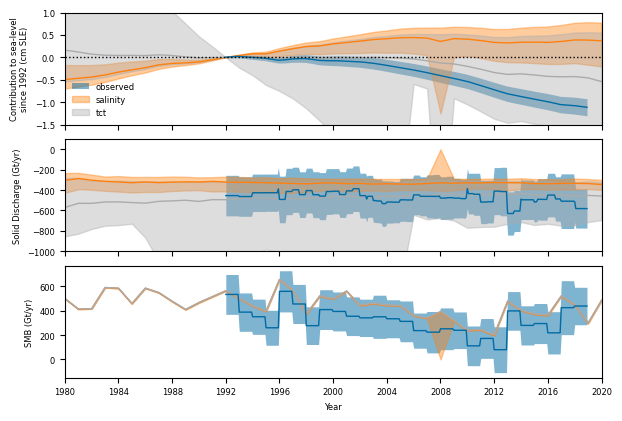

In [18]:
plt.rc('font', size=6)
plt.style.use("tableau-colorblind10")

fig, axs = plt.subplots(nrows=3, ncols=1, sharex="col", figsize=(6.2, 4.2))
fig.subplots_adjust(wspace=-0.5, hspace=-0.5)

obs_ci = axs[0].fill_between(imbie["Date"], 
                    (imbie["Mass (Gt)"] + sigma * imbie["Mass uncertainty (Gt)"]) * gt2cmsle, 
                    (imbie["Mass (Gt)"] - sigma * imbie["Mass uncertainty (Gt)"]) / 362.5 / 10.0, 
                    ls="solid", color=imbie_color, lw=0, alpha=0.5, label="observed")
axs[1].fill_between(imbie["Date"], 
                    (imbie["D (Gt/yr)"] + sigma * imbie["D uncertainty (Gt/yr)"]), 
                    (imbie["D (Gt/yr)"] - sigma * imbie["D uncertainty (Gt/yr)"]), 
                    ls="solid", color=imbie_color, lw=0, alpha=0.5)
axs[2].fill_between(imbie["Date"], 
                    (imbie["SMB (Gt/yr)"] + sigma * imbie["SMB uncertainty (Gt/yr)"]), 
                    (imbie["SMB (Gt/yr)"] - sigma * imbie["SMB uncertainty (Gt/yr)"]), 
                    ls="solid", color=imbie_color, lw=0, alpha=0.5)


# all_exps = pd.concat([experiments[e]["data_df"] for e in range(len(experiments))]).reset_index(drop=True)
# sns.lineplot(data=all_exps, x="time", y=mass_varname, hue="Experiment", palette=sim_colors[:2], ax=axs[0], estimator="median", ci=None)
# sns.lineplot(data=all_exps, x="time", y=flux_varname, hue="Experiment", palette=sim_colors[:2], ax=axs[1], estimator="median", ci=None)

for k, exp in enumerate(experiments):
    df = exp["data_df"]
    q_05 = df.groupby(by="time").quantile(0.05, numeric_only=True)
    q_50 = df.groupby(by="time").quantile(0.50, numeric_only=True)
    q_95 = df.groupby(by="time").quantile(0.95, numeric_only=True)
    axs[0].plot(q_50.index, q_50[mass_varname], color=sim_colors[k], alpha=1.0, lw=1)
    axs[1].plot(q_50.index, q_50[discharge_varname], color=sim_colors[k], alpha=1.0, lw=1)
    axs[2].plot(q_50.index, q_50[smb_varname], color=sim_colors[k], alpha=1.0, lw=1)

    axs[0].fill_between(q_05.index, q_05[mass_varname], 
                        q_95[mass_varname], color=sim_colors[k], alpha=0.4, lw=1, label=exp["Experiment"])
    axs[1].fill_between(q_05.index, q_05[discharge_varname], 
                        q_95[discharge_varname], color=sim_colors[k], alpha=0.4, lw=1)
    axs[2].fill_between(q_05.index, q_05[smb_varname], 
                        q_95[smb_varname], color=sim_colors[k], alpha=0.4, lw=1)

axs[0].plot(imbie["Date"], imbie["Mass (Gt)"] * gt2cmsle, color=imbie_color, lw=1)
axs[1].plot(imbie["Date"], imbie["D (Gt/yr)"], color=imbie_color, lw=1)
axs[2].plot(imbie["Date"], imbie["SMB (Gt/yr)"], color=imbie_color, lw=1)



fig.set_facecolor(bg_color)
for ax in axs:
    ax.set_facecolor(bg_color)
fig.set_facecolor(bg_color)

axs[0].axhline(0, color="k", ls="dotted", lw=1.0)
axs[0].set_xlabel("")
axs[0].set_ylabel("Contribution to sea-level\nsince 1992 (cm SLE)")
axs[-1].set_xlabel("Year")
axs[1].set_ylabel("Solid Discharge (Gt/yr)")
axs[2].set_ylabel("SMB (Gt/yr)")
axs[0].set_xlim(pd.to_datetime("1980-1-1"), pd.to_datetime("2020-1-1"))
axs[0].set_ylim(-1.5, 1.0)
axs[1].set_ylim(-1000, 100)
#axs[1].set_ylim(-1000, 100)

legend = axs[0].legend(loc="lower left")
legend.get_frame().set_linewidth(0.0)
legend.get_frame().set_alpha(0.0)
fig.tight_layout()
fig.savefig("ragis-comp_scalar.pdf")
!open ragis-comp_scalar.pdf

## Plot sensitivity index

In [ ]:
plt.rc('font', size=6)
plt.style.use("tableau-colorblind10")


for e in experiments:
    sa_df = e["sensitivity_df"]
    si = "S1"
    outfile = f"""{e["lhs"]}.pdf"""
    fig, axs = plt.subplots(
        2,
        1,
        sharex="col",
        figsize=[6.2, 3.8],
    )
    fig.subplots_adjust(bottom=0.0)
    for k, m_var in enumerate(["limnsw (kg)", "grounding_line_flux (Gt year-1)"]):
        m_df = sa_df[sa_df["Variable"] == m_var]
        ax = axs.ravel()[k]
        p_df = m_df[m_df["Si"] == si].drop(columns=["Si", "Variable"]).set_index("Date")
        p_conf_df = m_df[m_df["Si"] == si + "_conf"].drop(columns=["Si"])

        [
            ax.plot(p_df.index, p_df[v], lw=1, label=v)
            for v in sa_df.drop(columns=["Si", "Variable", "Date"]).keys()
        ]

        [
            ax.fill_between(
                p_df.index,
                p_df[v].values - p_conf_df[v].values,
                p_df[v].values + p_conf_df[v].values,
                alpha=0.2,
                lw=0,
            )
            for v in sa_df.drop(columns=["Si", "Variable", "Date"]).keys()
        ]
        ax.set_xlim(datetime(1980, 1, 1), datetime(2020, 1, 1))
        lgd = ax.set_title(f"{si} indices for '{m_var}'")
    legend = axs[-1].legend(loc="lower left", ncols=3, bbox_to_anchor=(0, -0.75))
    fig.tight_layout()
    fig.savefig(f"{si}_{outfile}")


In [ ]:
ragis_calib = resample_ensemble_by_data(imbie, experiments[1]["data_df"], 
                                        fudge_factor=100)
calib_exps = ragis_calib["Experiment"].unique()
print(calib_exps)

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharex="col", figsize=(12, 8))
fig.subplots_adjust(wspace=0.0, hspace=0.0)

q_5 = ragis_calib.groupby(by="Year").quantile(0.05)
q_16 = ragis_calib.groupby(by="Year").quantile(0.16)
q_50 = ragis_calib.groupby(by="Year").quantile(0.50)
q_84 = ragis_calib.groupby(by="Year").quantile(0.84)
q_95 = ragis_calib.groupby(by="Year").quantile(0.95)
for exp in calib_exps:
    e = data_df[data_df["Experiment"] == exp]
    axs[0].plot(e["Year"], e["Mass (Gt)"])
    axs[1].plot(e["Year"], e["D (Gt/yr)"])

# axs[0].fill_between(q_50.index, q_16["Mass (Gt)"], q_84["Mass (Gt)"], color="w")
axs[0].fill_between(imbie["Year"], 
                    (imbie["Mass (Gt)"] + sigma * imbie["Mass uncertainty (Gt)"]), 
                    (imbie["Mass (Gt)"] - sigma * imbie["Mass uncertainty (Gt)"]), 
                    ls="solid", lw=0, alpha=0.5, color="#6baed6", label="2-$\sigma$ IMBIE")
axs[1].fill_between(imbie["Year"], 
                    (imbie["D (Gt/yr)"] + sigma * imbie["D uncertainty (Gt/yr)"]), 
                    (imbie["D (Gt/yr)"] - sigma * imbie["D uncertainty (Gt/yr)"]), 
                    ls="solid", lw=0, alpha=1, color=imbie_color)


axs[0].set_xlim(1992, 2017)
fig.set_facecolor(bg_color)
for ax in axs:
    ax.set_facecolor(bg_color)
fig.set_facecolor(bg_color)




In [ ]:
sensitivity_analysis?

In [ ]:
help(analysis.sensitivity_analysis)

In [ ]:
from pismragis import processing, analysis

In [ ]:
processing.ncfile2dataframe?

In [ ]:
analysis.prepare_df?